In [42]:
pip show FastKmedoids

Name: FastKmedoids
Version: 0.0.39
Summary: FastKmedoids is a Python package to apply the clustering algorithms Fast Kmedoids and KFold Fast Kmedoids.
Home-page: https://github.com/FabioScielzoOrtiz/FastKmedoids-package
Author: Fabio Scielzo Ortiz
Author-email: fabioscielzo98@gmail.com
License: 
Location: c:\Users\fscielzo\Documents\Proyectos\FastKmedoids\FastKmedoids-demo\.venv\Lib\site-packages
Requires: numpy, polars
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import time
import numpy as np
import pandas as pd
import polars as pl
from sklearn.datasets import make_blobs
from FastKmedoids.data import outlier_contamination
from FastKmedoids.models import FastKmedoidsGGower, FastGGowerDistMatrix
from FastKmedoids.plots import clustering_MDS_plot_one_method, clustering_MDS_plot_multiple_methods
from FastKmedoids.metrics import adjusted_accuracy
from sklearn.manifold import MDS
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.mixture import GaussianMixture
from sklearn_extra.cluster import CLARA
from sklearn.cluster import KMeans
from BigEDA.descriptive import outliers_table
from BigEDA.plots import boxplot_matrix, histogram_matrix, barplot_matrix

In [44]:
X, Y = make_blobs(n_samples=35000, centers=4, cluster_std=[2,2,2,3], n_features=8, random_state=123)
X = pd.DataFrame(X)      
X.columns = [f"X{i}" for i in range(1, X.shape[1]+1)]

# Se convierten dos variables cuantitativas a binarias, y otras dos a multiclase, discretizandolas.
X['X5'] = pd.cut(X['X5'], bins=[X['X5'].min()-1, X['X5'].mean(), X['X5'].max()+1], labels=False)
X['X6'] = pd.cut(X['X6'], bins=[X['X6'].min()-1, X['X6'].mean(), X['X6'].max()+1], labels=False)
X['X7'] = pd.cut(X['X7'], bins=[X['X7'].min()-1, X['X7'].quantile(0.25), X['X7'].quantile(0.50), X['X7'].quantile(0.75), X['X7'].max()+1], labels=False)
X['X8'] = pd.cut(X['X8'], bins=[X['X8'].min()-1, X['X8'].quantile(0.25), X['X8'].quantile(0.50), X['X8'].quantile(0.75), X['X8'].max()+1], labels=False)   

X_outliers, outliers_idx_X1 = outlier_contamination(X, col_name='X1', prop_above=0.1, sigma=3, random_state=123)
X_outliers, outliers_idx_X2 = outlier_contamination(X_outliers, col_name='X2', prop_below=0.1, sigma=5, random_state=123)
X_outliers_pl = pl.from_pandas(X_outliers)
X_not_outliers_pl = pl.from_pandas(X)

X = X_outliers.copy()

In [45]:
if np.array_equal(outliers_idx_X1, outliers_idx_X2):
    print('equal')
    outlier_idx = outliers_idx_X1.copy()
else:
    print('not equal')
    outlier_idx = np.unique(np.concatenate((outliers_idx_X1, outliers_idx_X2)))

not equal


In [46]:
X.head()

,X1,X2,X3,X4,X5,X6,X7,X8
0,-2.651313,0.425178,-4.840969,4.436158,0,0,0,2
1,-41.469161,-47.546455,-0.516458,-1.903982,0,1,0,0
2,6.366665,2.813932,-2.505519,-7.371732,0,1,0,0
3,-5.000105,-7.485500,3.060407,4.966358,0,1,2,1
4,-4.931669,-6.980633,2.779526,-2.976350,1,1,2,2


In [ ]:
outliers_table(X_not_outliers_pl, auto=False, col_names=['X1', 'X2', 'X3', 'X4'], h=1.5)

In [ ]:
outliers_table(X_outliers_pl, auto=False, col_names=['X1', 'X2', 'X3', 'X4'], h=1.5)

In [ ]:
boxplot_matrix(X_not_outliers_pl, n_cols=2, title='Box-plot - Quantitative variables - Before outliers contamination', 
               figsize=(10,5), quant_col_names=['X1', 'X2', 'X3', 'X4'], n_xticks=6, title_fontsize=13, 
               save=True, file_name='plots/simu_1_boxplot_1', x_rotation=0, title_height=0.99,
               style='whitegrid', hspace=0.7, wspace=0.15, title_weight='bold',
               subtitles_fontsize=12, xlabel_size=10)

In [ ]:
boxplot_matrix(X_outliers_pl, n_cols=2, title='Box-plot - Quantitative variables - After outliers contamination', 
               figsize=(10,5), quant_col_names=['X1', 'X2', 'X3', 'X4'], n_xticks=6, title_fontsize=13, 
               save=True, file_name='plots/simu_1_boxplot_2', x_rotation=0, title_height=0.99,
               style='whitegrid', hspace=0.7, wspace=0.15, title_weight='bold',
               subtitles_fontsize=12, xlabel_size=10)

In [47]:
start_time = time.time()

fast_kmedoids = FastKmedoidsGGower(n_clusters=4, method='pam', init='heuristic', max_iter=100, random_state=111,
                                   frac_sample_size=0.01, p1=4, p2=2, p3=2, 
                                   d1='robust_mahalanobis', d2='jaccard', d3='hamming', 
                                   robust_method='trimmed', alpha=0.05, epsilon=0.05, n_iters=20)

fast_kmedoids.fit(X) 

time_fast_kmedoids = time.time() - start_time

cluster_labels_fast_kmedoids = fast_kmedoids.labels_

In [48]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=111) 

fastGGower = FastGGowerDistMatrix(frac_sample_size=0.03, random_state=111, p1=4, p2=2, p3=2, 
                                  d1='robust_mahalanobis', d2='sokal', d3='hamming', 
                                  robust_method='winsorized', alpha=0.08)

fastGGower.compute(X)

D_GGower = fastGGower.D_GGower

X_mds = mds.fit_transform(D_GGower)

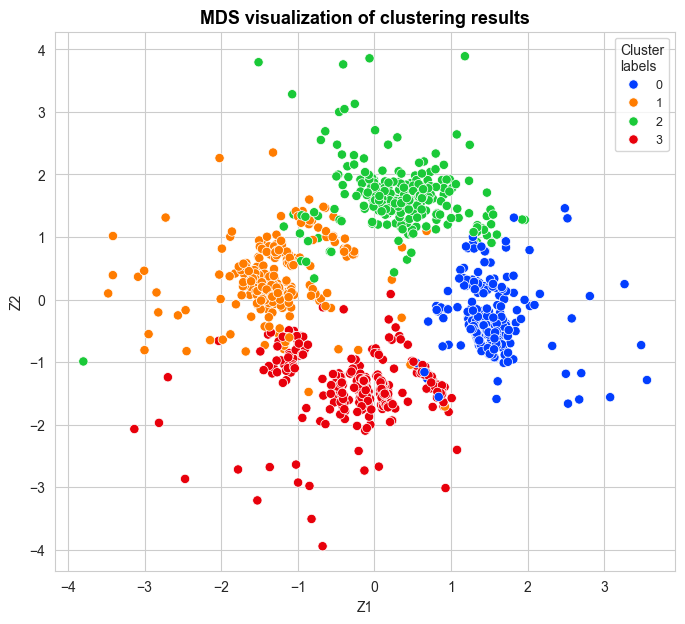

In [49]:
clustering_MDS_plot_one_method(X_mds=X_mds, y_pred=cluster_labels_fast_kmedoids[fastGGower.sample_index], 
                               y_true=None, title="MDS visualization of clustering results", 
                               accuracy=None, time=None, 
                               figsize=(8,7), bbox_to_anchor=(1,1), 
                               title_size=13, title_weight='bold', 
                               points_size=45, title_height=1, 
                               save=False, legend_size=9)

In [50]:
adj_accuracy_fast_kmedoids, adj_cluster_labels_fast_kmedoids = adjusted_accuracy(y_pred=cluster_labels_fast_kmedoids, y_true=Y)

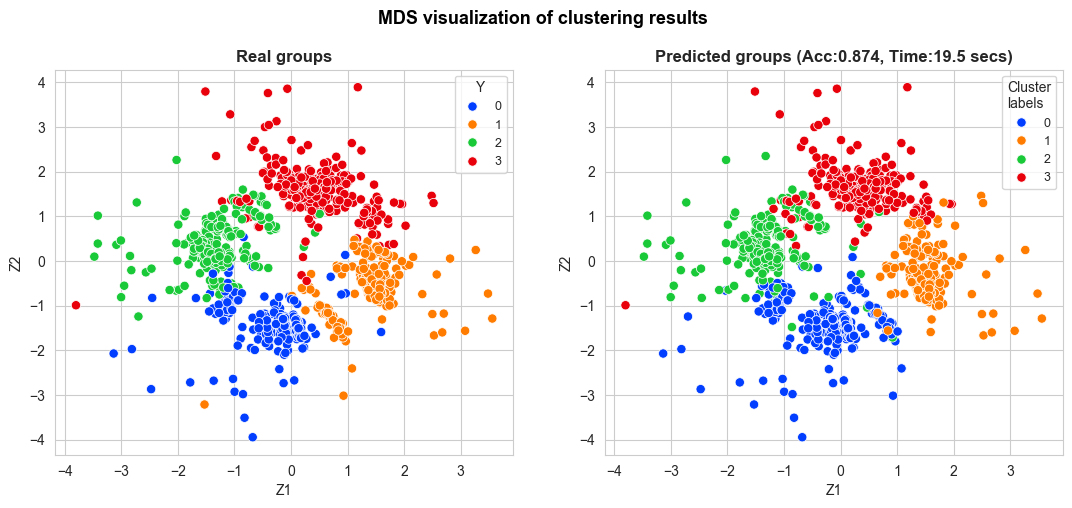

In [51]:
clustering_MDS_plot_one_method(X_mds=X_mds, 
                               y_pred=adj_cluster_labels_fast_kmedoids[fastGGower.sample_index], 
                               y_true=Y[fastGGower.sample_index],
                               title="MDS visualization of clustering results", 
                               accuracy=adj_accuracy_fast_kmedoids, 
                               time=time_fast_kmedoids, 
                               figsize=(13,5), bbox_to_anchor=(1,1), 
                               title_size=13, title_weight='bold', 
                               points_size=45, title_height=1, 
                               save=False, legend_size=9, wspace=0.2)


In [52]:
start_time = time.time()
kmeans = KMeans(n_clusters=4, random_state=123, init='k-means++', n_init='auto', max_iter=300)
kmeans.fit(X)
cluster_labels_kmeans = kmeans.labels_
time_kmeans = time.time() - start_time

start_time = time.time()
gmm = GaussianMixture(n_components=4, random_state=123)
gmm.fit(X)
cluster_labels_gmm = gmm.predict(X)
time_gmm = time.time() - start_time

In [53]:
adj_accuracy_kmeans, adj_cluster_labels_kmeans = adjusted_accuracy(y_pred=cluster_labels_kmeans, y_true=Y)
adj_accuracy_gmm, adj_cluster_labels_gmm = adjusted_accuracy(y_pred=cluster_labels_gmm, y_true=Y)

In [ ]:
y_pred = {
          'FastKmedoids-RobustGGower': adj_cluster_labels_fast_kmedoids[fastGGower.sample_index],
          'Kmeans': adj_cluster_labels_kmeans[fastGGower.sample_index],
          'GMM': adj_cluster_labels_gmm[fastGGower.sample_index]
          }

In [ ]:
accuracy = {
            'FastKmedoids-RobustGGower': adj_accuracy_fast_kmedoids,
            'Kmeans': adj_accuracy_kmeans,
            'GMM': adj_accuracy_gmm
            }

In [ ]:
time_ = {
        'FastKmedoids-RobustGGower': time_fast_kmedoids,
        'Kmeans': time_kmeans,
        'GMM': time_gmm
        }

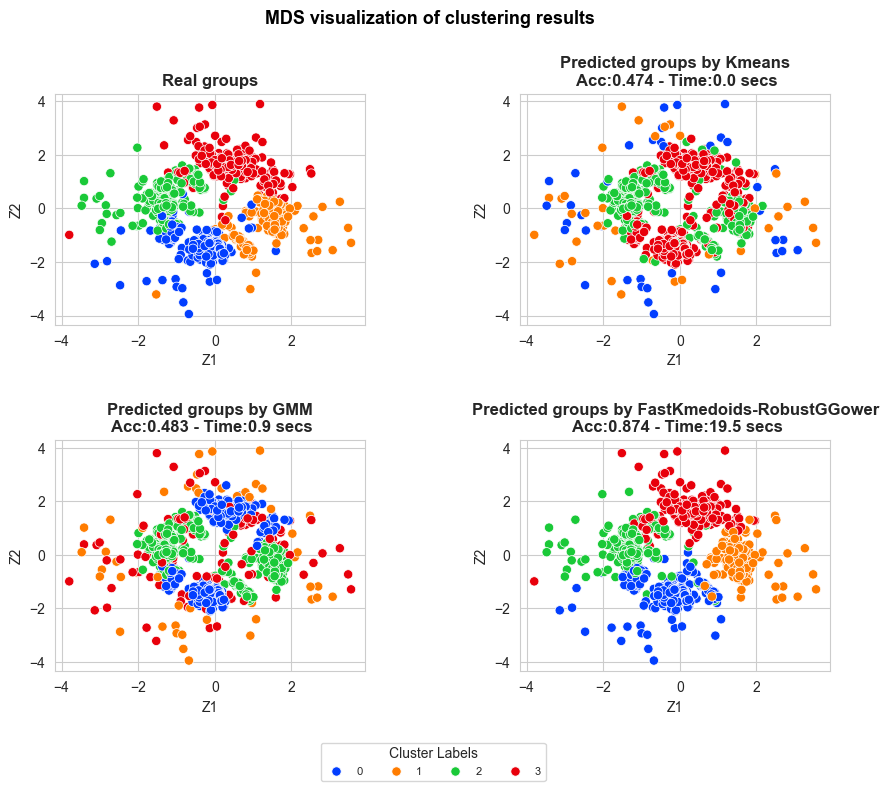

In [57]:
clustering_MDS_plot_multiple_methods(X_mds=X_mds, y_pred=y_pred, 
                                     y_true=Y[fastGGower.sample_index],
                                     title="MDS visualization of clustering results", 
                                     accuracy=accuracy, time=time_, n_rows=3,
                                     figsize=(10,12), bbox_to_anchor=(0.1,-2), 
                                     title_size=13, title_weight='bold', 
                                     points_size=45, title_height=0.95, 
                                     save=False, legend_size=8, 
                                     wspace=0.5, hspace=0.5, 
                                     legend_title='Cluster Labels',
                                     n_cols_legend=4)

In [58]:
outliers_boolean = np.array([0 if x not in outlier_idx else 1 for x in range(0, len(X))])

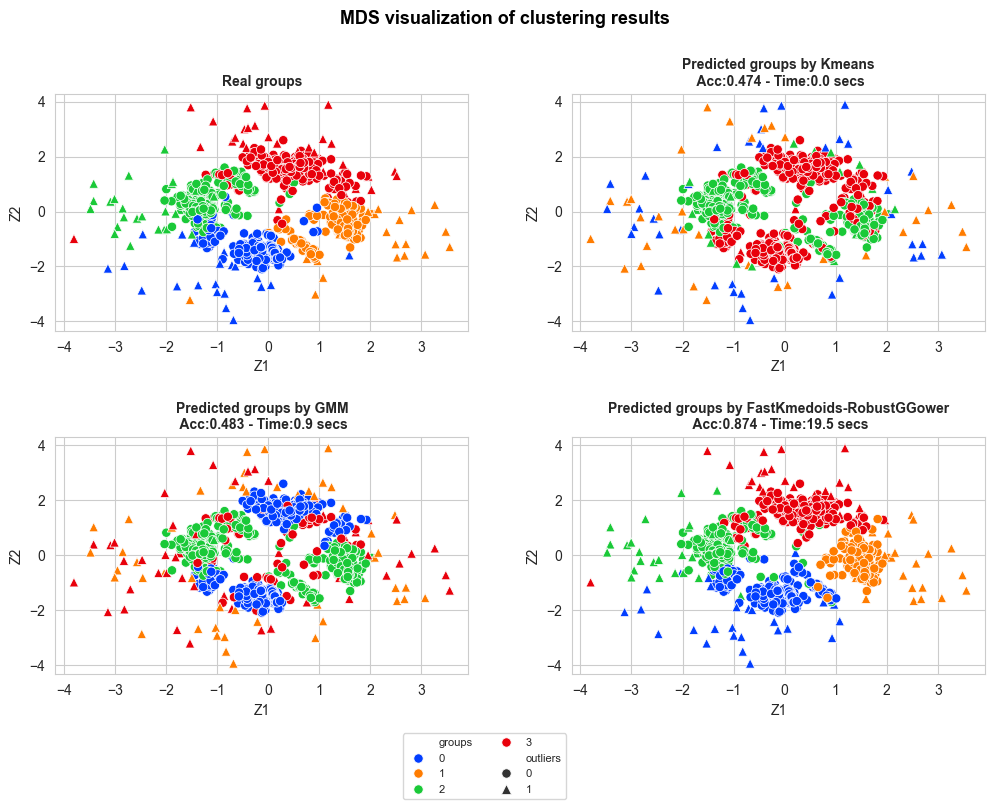

In [78]:
clustering_MDS_plot_multiple_methods(X_mds=X_mds, y_pred=y_pred, 
                                     y_true=Y[fastGGower.sample_index],
                                     title="MDS visualization of clustering results", 
                                     accuracy=accuracy, time=time_, n_rows=3,
                                     figsize=(12,12), bbox_to_anchor=(0,-2), 
                                     title_size=13, title_weight='bold', 
                                     subtitles_size=10,
                                     points_size=45, title_height=0.95, 
                                     save=False, legend_size=8, 
                                     wspace=0.25, hspace=0.45, 
                                     outliers_boolean=outliers_boolean[fastGGower.sample_index],
                                     n_cols_legend=2, legend_title='')